## Part 0: Libraries and Set Up Jargon

In [ ]:
!pip3 install penngrader-client
!pip install sqlalchemy==1.4.46
!pip install pandasql
!pip install geopy
!pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.2 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.27
    Uninstalling SQLAlchemy-2.0.27:
      Successfully uninstalled SQLAlchemy-2.0.27
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.46 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=b4ccd0126b167d4e4bf528b86353577f577c3bcb17ffe3700dadd8043dcf65e8
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.7 MB

In [ ]:
from penngrader.grader import *
import pandas as pd
import datetime as dt
import geopy.distance as gp
import matplotlib.image as mpimg
import plotly.express as px
import pandasql as ps #SQL on Pandas Dataframe
import nltk
nltk.download('punkt')

from wordcloud import WordCloud

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
! wget -nc https://storage.googleapis.com/penn-cis5450/indego_trips.csv
! wget -nc https://storage.googleapis.com/penn-cis5450/indego_stations.csv
! wget -nc https://storage.googleapis.com/penn-cis5450/weather_2022_PHL.csv
! wget -nc https://storage.googleapis.com/penn-cis5450/restaurant_reviews.csv

--2024-02-27 18:47:27--  https://storage.googleapis.com/penn-cis5450/indego_trips.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.111.207, 142.251.16.207, 172.253.62.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.111.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2033339 (1.9M) [text/csv]
Saving to: ‘indego_trips.csv’

indego_trips.csv    100%[===================>]   1.94M  --.-KB/s    in 0.03s   

2024-02-27 18:47:27 (65.0 MB/s) - ‘indego_trips.csv’ saved [2033339/2033339]

--2024-02-27 18:47:27--  https://storage.googleapis.com/penn-cis5450/indego_stations.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.111.207, 142.251.16.207, 172.253.62.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.111.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9052 (8.8K) [text/csv]
Saving to: ‘indego_stations.csv’

indego_stations.csv 

# Biking in Philadelphia

## Part 1: Load & Process our Datasets

In [ ]:
trips_df = pd.read_csv('indego_trips.csv')
stations_df = pd.read_csv('indego_stations.csv')
weather_df = pd.read_csv('weather_2022_PHL.csv')
reviews_df = pd.read_csv('restaurant_reviews.csv')

In [ ]:
trips_df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,536547052,9,10/1/2022 0:00,10/1/2022 0:09,3190.0,39.948921,-75.169907,3158.0,39.925522,-75.169037,23553,30.0,One Way,Indego30,electric
1,536547050,19,10/1/2022 0:01,10/1/2022 0:20,3168.0,39.951340,-75.173943,3034.0,39.933151,-75.162483,22190,30.0,One Way,Indego30,electric
2,536547048,12,10/1/2022 0:02,10/1/2022 0:14,3190.0,39.948921,-75.169907,3158.0,39.925522,-75.169037,18789,30.0,One Way,Indego30,electric
3,536547046,5,10/1/2022 0:03,10/1/2022 0:08,3075.0,39.967178,-75.161247,3039.0,39.971569,-75.159927,23383,30.0,One Way,Indego30,electric
4,536547044,11,10/1/2022 0:03,10/1/2022 0:14,3050.0,39.953388,-75.154259,3075.0,39.967178,-75.161247,5367,30.0,One Way,Indego30,standard


In [ ]:
stations_df.head()

,station_id,station_name,day_of_go_live_date,status,zone
0,3000,Virtual Station,4/23/2015,Active,0
1,3004,Municipal Services Building Plaza,4/23/2015,Active,0
2,3005,"Welcome Park, NPS",4/23/2015,Active,0
3,3006,40th & Spruce,4/23/2015,Active,2
4,3007,"11th & Pine, Kahn Park",4/23/2015,Active,0


In [ ]:
weather_df.head()

,date,actual_mean_temp,actual_min_temp,actual_max_temp,average_min_temp,average_max_temp,record_min_temp,record_max_temp,record_min_temp_year,record_max_temp_year,actual_precipitation,average_precipitation,record_precipitation
0,1/1/2022,35,28,42,27,41,4,64,1881,2005,0.00,0.09,1.60
1,1/2/2022,37,29,44,26,41,7,67,1968,1876,0.00,0.10,1.68
2,1/3/2022,36,28,44,26,41,-3,63,1879,2000,0.72,0.09,1.50
3,1/4/2022,50,42,58,26,41,2,68,1918,1950,0.37,0.10,1.51
4,1/5/2022,37,24,50,26,40,-2,66,1904,1997,0.00,0.10,2.24


In [ ]:
reviews_df.head()

,restaurant,review,zone
0,Gloria Restaurant,Today is the third time I've come to Gloria Re...,1
1,Gloria Restaurant,I have been to Gloria Restaurant a couple time...,1
2,Gloria Restaurant,Last Saturday I went to this restaurant hoping...,1
3,Gloria Restaurant,"First off, let me say I have never been to the...",1
4,Gloria Restaurant,I've been coming here for a while now and I wa...,1


### 1.1 Data Preprocessing

In [ ]:
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15502 entries, 0 to 15501
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trip_id              15502 non-null  int64  
 1   duration             15502 non-null  int64  
 2   start_time           15502 non-null  object 
 3   end_time             15502 non-null  object 
 4   start_station        15477 non-null  float64
 5   start_lat            15477 non-null  float64
 6   start_lon            15477 non-null  float64
 7   end_station          15477 non-null  float64
 8   end_lat              15255 non-null  float64
 9   end_lon              15255 non-null  float64
 10  bike_id              15477 non-null  object 
 11  plan_duration        15477 non-null  float64
 12  trip_route_category  15477 non-null  object 
 13  passholder_type      15477 non-null  object 
 14  bike_type            15477 non-null  object 
dtypes: float64(7), int64(2), object(6)
m

#### 1.1.1 Cleaning `trips_df`

In [ ]:
trips_cleaned_df = trips_df.drop(['plan_duration'], axis=1)

In [ ]:
trips_cleaned_df = trips_cleaned_df[trips_cleaned_df['end_station'] != 3000]

In [ ]:
trips_cleaned_df = trips_cleaned_df.dropna()

In [ ]:
trips_cleaned_df['start_time'] = trips_cleaned_df['start_time'].astype('string')
trips_cleaned_df['end_time'] = trips_cleaned_df['end_time'].astype('string')
trips_cleaned_df['trip_route_category'] = trips_cleaned_df['trip_route_category'].astype('string')
trips_cleaned_df['passholder_type'] = trips_cleaned_df['passholder_type'].astype('string')
trips_cleaned_df['bike_type'] = trips_cleaned_df['bike_type'].astype('string')
trips_cleaned_df['bike_id'] = trips_cleaned_df['bike_id'].astype('int')

<ipython-input-17-bafc53f54298>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_cleaned_df['start_time'] = trips_cleaned_df['start_time'].astype('string')
<ipython-input-17-bafc53f54298>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_cleaned_df['end_time'] = trips_cleaned_df['end_time'].astype('string')
<ipython-input-17-bafc53f54298>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [ ]:
trips_cleaned_df = trips_cleaned_df.sort_values('trip_id', ascending = True)

#### 1.1.2 Processing Stations

In [ ]:
stations_df['day_of_go_live_date'] = pd.to_datetime(stations_df['day_of_go_live_date'])

stations_df = stations_df[stations_df['day_of_go_live_date'] <= '2022-10-07']

stations_df = stations_df[stations_df['status'] != 'Inactive']

stations_df.drop(['day_of_go_live_date', 'status'], axis = 1, inplace = True)

stations_df['is_west_philly'] = stations_df['zone'].apply(lambda x: x in [2, 3])

stations_cleaned_df = stations_df.sort_values(by = 'station_id').reset_index(drop = True)

#### 1.1.3 Cleaning the weather

In [ ]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   365 non-null    object 
 1   actual_mean_temp       365 non-null    int64  
 2   actual_min_temp        365 non-null    int64  
 3   actual_max_temp        365 non-null    int64  
 4   average_min_temp       365 non-null    int64  
 5   average_max_temp       365 non-null    int64  
 6   record_min_temp        365 non-null    int64  
 7   record_max_temp        365 non-null    int64  
 8   record_min_temp_year   365 non-null    int64  
 9   record_max_temp_year   365 non-null    int64  
 10  actual_precipitation   365 non-null    float64
 11  average_precipitation  365 non-null    float64
 12  record_precipitation   365 non-null    float64
dtypes: float64(3), int64(9), object(1)
memory usage: 37.2+ KB


In [ ]:
weather_cleaned_df = weather_df[['date', 'actual_mean_temp', 'actual_min_temp', 'actual_max_temp', 'actual_precipitation']]\

weather_cleaned_df['date'] = pd.to_datetime(weather_cleaned_df['date'])

weather_cleaned_df = weather_cleaned_df[(weather_cleaned_df['date'] >= '2022-09-01') & (weather_cleaned_df['date'] <= '2022-10-31')]

weather_cleaned_df = weather_cleaned_df.sort_values(by='date', ascending=False).reset_index(drop = True)

<ipython-input-23-3e95b0cf465e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_cleaned_df['date'] = pd.to_datetime(weather_cleaned_df['date'])


## Part 2: Exploring the Data with Pandas

### 2.1 One Way vs Round Trip [22 points]

#### 2.1.1 How many of the rides taken were Round Trip journeys?

In [ ]:
# Filter the DataFrame for only round trips
round_df = trips_cleaned_df[trips_cleaned_df['trip_route_category'] == 'Round Trip']

# Sort by trip_id in ascending order
round_df = round_df.sort_values(by='trip_id', ascending=True)

In [ ]:
# Count the number of round trips
number_of_rounds = round_df.shape[0]

In [ ]:
round_query = """
SELECT COUNT(*) as num
FROM trips_cleaned_df
WHERE trip_route_category = 'Round Trip'
"""
round_df_sql = ps.sqldf(round_query, locals())
round_df_sql

,num
0,930


#### 2.1.2 What was the duration of these round trips?




In [ ]:
avg_round_pd = round_df['duration'].mean()

In [ ]:
avg_dur_query = """
SELECT AVG(duration) as avg_dur
FROM round_df
"""

avg_round_df = ps.sqldf(avg_dur_query, locals())
avg_round_df

,avg_dur
0,20.107527


#### 2.1.3 How long do you take?

In [ ]:
day_df_pd = trips_cleaned_df[trips_cleaned_df['passholder_type'] == 'Day Pass']['duration'].mean()

In [ ]:
day_query = """
            SELECT AVG(duration) AS avg_dur
            FROM trips_cleaned_df
            WHERE passholder_type = 'Day Pass'
            """
day_df_sql = ps.sqldf(day_query, locals())
day_df_sql

,avg_dur
0,31.43299


#### 2.1.4 Ratio of Rides

In [ ]:
# Calculate the number of one-way and round-trip rides
num_one_way = trips_cleaned_df[trips_cleaned_df['trip_route_category'] == 'One Way'].shape[0]
num_round_trip = trips_cleaned_df[trips_cleaned_df['trip_route_category'] == 'Round Trip'].shape[0]

# Calculate the ratio
ratio_1_round = num_one_way / num_round_trip

In [ ]:
ratio_query = """
              SELECT
                (SELECT CAST(COUNT(*) AS FLOAT) FROM trips_cleaned_df WHERE trip_route_category = 'One Way') /
                (SELECT COUNT(*) FROM trips_cleaned_df WHERE trip_route_category = 'Round Trip') AS ratio
              """
0
ratio_df = ps.sqldf(ratio_query, locals())
ratio_df

,ratio
0,15.403226


###2.2 Station Involvement

#### 2.2.1 Names not numbers

In [ ]:
trips_cleaned_df.dropna(inplace = True)

In [ ]:
trips_final_df = trips_cleaned_df.copy()

In [ ]:
# Assuming the structure of stations_cleaned_df and creating a mapping dictionary
station_id_name_mapping = stations_cleaned_df.set_index('station_id')['station_name'].to_dict()

# Replace start_station IDs with names
trips_final_df['start_station'] = trips_final_df['start_station'].map(station_id_name_mapping).fillna('Unknown')

# Replace end_station IDs with names
trips_final_df['end_station'] = trips_final_df['end_station'].map(station_id_name_mapping).fillna('Unknown')

In [ ]:
trips_final_df = trips_final_df.sort_values(by = 'trip_id', ascending = True).reset_index(drop = True)

In [ ]:
#Use pandasql to replace station IDs with station names in trips_cleaned_df and save it as trips_stations_sql
replace_query = """
                SELECT t.trip_id,
                      t.duration,
                      t.start_time,
                      t.end_time,
                      COALESCE(s1.station_name, t.start_station) AS start_station,
                      t.start_lat,
                      t.start_lon,
                      COALESCE(s2.station_name, t.end_station) AS end_station,
                      t.end_lat,
                      t.end_lon,
                      t.bike_id,
                      t.trip_route_category,
                      t.passholder_type,
                      t.bike_type
                FROM trips_cleaned_df AS t
                LEFT JOIN stations_cleaned_df AS s1 ON t.start_station = s1.station_id
                LEFT JOIN stations_cleaned_df AS s2 ON t.end_station = s2.station_id;
                """
trips_stations_sql = ps.sqldf(replace_query, locals())
trips_stations_sql

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,trip_route_category,passholder_type,bike_type
0,536546924,3,10/1/2022 1:50,10/1/2022 1:53,"Broad & Pattison, BSL",39.904709,-75.173401,"Broad & Pattison, BSL",39.904709,-75.173401,11708,Round Trip,Indego30,standard
1,536546925,3,10/1/2022 1:50,10/1/2022 1:53,"Broad & Pattison, BSL",39.904709,-75.173401,"Broad & Pattison, BSL",39.904709,-75.173401,3483,Round Trip,Indego30,standard
2,536546927,7,10/1/2022 1:48,10/1/2022 1:55,15th & Spruce,39.947109,-75.166183,"18th & Washington, Chew Playground",39.938400,-75.173271,14655,One Way,Indego30,standard
3,536546929,7,10/1/2022 1:48,10/1/2022 1:55,15th & Spruce,39.947109,-75.166183,"18th & Washington, Chew Playground",39.938400,-75.173271,12987,One Way,Indego30,standard
4,536546932,6,10/1/2022 1:41,10/1/2022 1:47,Municipal Services Building Plaza,39.953781,-75.163742,18th & Chestnut,39.951740,-75.170631,22554,One Way,Day Pass,electric
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15250,540422839,100,10/7/2022 21:36,10/7/2022 23:16,13th & Locust,39.947922,-75.162369,13th & Locust,39.947922,-75.162369,22404,Round Trip,Day Pass,electric
15251,540422840,102,10/7/2022 21:35,10/7/2022 23:17,13th & Locust,39.947922,-75.162369,13th & Locust,39.947922,-75.162369,23321,Round Trip,Day Pass,electric
15252,540422841,102,10/7/2022 21:34,10/7/2022 23:16,13th & Locust,39.947922,-75.162369,13th & Locust,39.947922,-75.162369,22950,Round Trip,Day Pass,electric
15253,540422860,50,10/7/2022 21:27,10/7/2022 22:17,12th & Chestnut,39.950249,-75.160278,Broad & Girard,39.971569,-75.159927,14533,One Way,Indego30,standard


#### 2.2.2 Morning Class?

In [ ]:
trips_final_df['hour'] = trips_final_df['start_time'].apply(lambda x: pd.Timestamp(x).hour)

In [ ]:
ucity_query = """
              SELECT COUNT(*) AS ride_count
              FROM trips_final_df
              WHERE start_station = 'University City Station' AND hour < 12;
              """

ucity_df = ps.sqldf(ucity_query, locals())
ucity_df

,ride_count
0,23


#### 2.2.3 Most Popular Stations

In [ ]:
#Return the top three used stations by number of rides
top3_query = """
            SELECT start_station AS Station, COUNT(*) AS Count_rides
            FROM trips_final_df
            GROUP BY start_station
            ORDER BY Count_rides DESC
            LIMIT 3;
            """

top3_df = ps.sqldf(top3_query, locals())
top3_df

,Station,Count_rides
0,17th & Locust,267
1,12th & Chestnut,238
2,15th & Spruce,233


### 2.3 Determining the Distance

In [ ]:
#Use pandasql to obtain the latitude and longitude of the start and end stations for ride ID 540422637.
latlng_query = """
              SELECT start_lat, start_lon, end_lat, end_lon
              FROM trips_final_df
              WHERE trip_id = 540422637;
              """

latlng_df = ps.sqldf(latlng_query, locals())
latlng_df

,start_lat,start_lon,end_lat,end_lon
0,39.947109,-75.166183,39.927769,-75.151031


In [ ]:
coords_1 = (latlng_df['start_lat'].iloc[0], latlng_df['start_lon'].iloc[0])
coords_2 = (latlng_df['end_lat'].iloc[0], latlng_df['end_lon'].iloc[0])

In [ ]:
#Use geopy to calculate the distance between the two stations
from geopy.distance import geodesic

final_dist = geodesic(coords_1, coords_2).miles

### 2.4 Destinations from Amtrak Station

In [ ]:
filtered_df = trips_final_df[ (trips_final_df['start_station'] == 'Amtrak 30th Street Station') &
                            (trips_final_df['duration'] >= 15) &
                            (trips_final_df['end_station'] != 'Amtrak 30th Street Station')]
end_station_df = filtered_df.groupby('end_station').size().reset_index(name = 'Count')
end_station_df = end_station_df.sort_values(by = ['Count','end_station'], ascending = [False, True]).head(5)


In [ ]:
end_station_query = """
                    SELECT end_station, COUNT(*) AS Count
                    FROM trips_final_df
                    WHERE start_station = 'Amtrak 30th Street Station'
                    AND duration >= 15
                    AND end_station != 'Amtrak 30th Street Station'
                    GROUP BY end_station
                    ORDER BY Count DESC, end_station
                    LIMIT 5
                    """

sql_end_station_df = ps.sqldf(end_station_query, locals())
sql_end_station_df

,end_station,Count
0,Broad & Chestnut,3
1,Schuylkill Banks Pergola,3
2,12th & Callowhill,2
3,12th & Filbert,2
4,16th & Montgomery,2


### 2.5 Weather and Trip Data

#### 2.5.1 Trips and Weather Tables

In [ ]:
weather_merge_df = weather_cleaned_df[['date', 'actual_max_temp','actual_precipitation']]
trips_final_df['start_time'] = pd.to_datetime(trips_final_df['start_time'])
trips_final_df['date'] = trips_final_df['start_time'].dt.date
trips_final_df['date'] = pd.to_datetime(trips_final_df['date'])
trips_merge_df = trips_final_df[['date', 'bike_type', 'start_station', 'trip_id']]

#### 2.5.2 Standard Riding on Spruce (SQL)

In [ ]:
#Create percentage_df
percentage_query = '''
SELECT
 w.actual_max_temp AS Temperature,
 CAST(100 * SUM(CASE WHEN t.bike_type = 'standard' THEN 1 ELSE 0 END) / COUNT(*) AS INTEGER) AS Standard_Percentage
FROM trips_merge_df AS t
JOIN weather_merge_df AS w USING(date)
WHERE
  t.start_station LIKE '%Spruce%'
  AND w.actual_precipitation < 0.3
GROUP BY
  1
ORDER BY
  1
                   '''

percentage_df = ps.sqldf(percentage_query, locals())
percentage_df

,Temperature,Standard_Percentage
0,61,49
1,70,51
2,72,56
3,73,58


#### 2.5.3 Rainy Days vs Non-Rainy Days

In [ ]:
rain_query = """
SELECT
  CASE WHEN w.actual_precipitation > 0 THEN 'Rainy Day' ELSE 'Sunny Day' END AS 'Day Type',
  COUNT(*) AS 'Number of Rides',
  COUNT(DISTINCT t.date) AS 'Number of Days'
FROM
  trips_merge_df AS t
JOIN
  weather_merge_df AS w USING(date)
GROUP BY
  1
             """

sql_rain_df = ps.sqldf(rain_query, locals())
sql_rain_df

,Day Type,Number of Rides,Number of Days
0,Rainy Day,6419,3
1,Sunny Day,8836,4


## Part 3: Data Visualization

In [ ]:
from datetime import datetime
import seaborn as sns

In [ ]:
trips_final_df['start_time'] = pd.to_datetime(trips_final_df['start_time'])

trips_final_df['Time'] = trips_final_df['start_time'].dt.time


In [ ]:
trips_final_df['Rounded_Time'] = trips_final_df['start_time'].dt.floor('H').dt.time


In [ ]:
# Ensure 'start_time' is in datetime format if not already done
trips_final_df['start_time'] = pd.to_datetime(trips_final_df['start_time'])

# Extract the date part from 'start_time' and create a new column 'Date'
trips_final_df['Date'] = trips_final_df['start_time'].dt.date


In [ ]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

trips_final_df['Day'] = pd.to_datetime(trips_final_df['Date']).dt.weekday.apply(lambda x: days[x])

trips_final_df.drop(columns=['Date'], inplace=True)

In [ ]:
selected_columns_df = trips_final_df[['trip_id', 'duration', 'Rounded_Time', 'Day']]



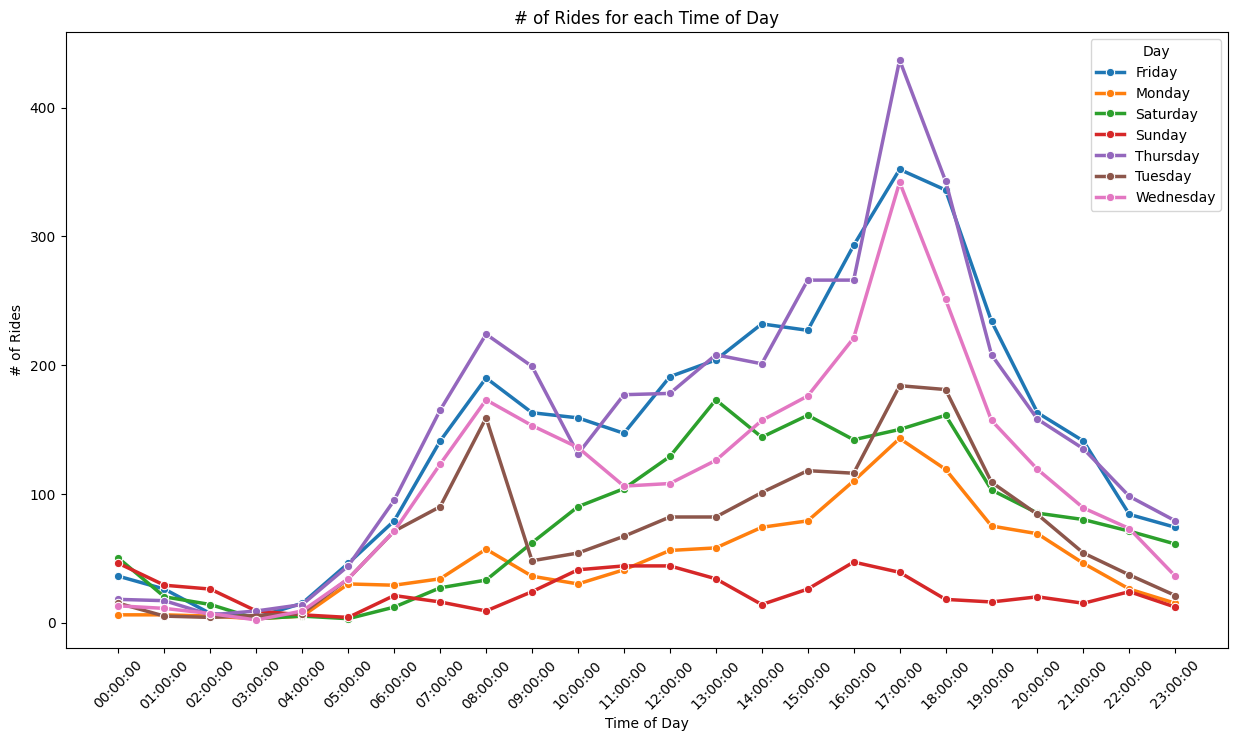

In [ ]:
# For this plot, create a dataframe that does not the duration column
plot1_df = selected_columns_df.drop(['duration'],axis = 1)

agg_df = plot1_df.groupby(['Day', 'Rounded_Time']).size().reset_index(name='Count')

agg_df.rename({'Rounded_Time': 'Time of Day'}, axis = 1, inplace=True)

agg_df['Time of Day'] = agg_df['Time of Day'].astype(str)

agg_df = agg_df[['Day', 'Time of Day', 'Count']]

plt.figure(figsize=(15, 8))
line_plot = sns.lineplot(data=agg_df, x='Time of Day', y='Count', hue='Day', marker='o', palette='tab10', linewidth=2.5)

plt.title('# of Rides for each Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('# of Rides')
plt.xticks(rotation=45)

plt.show()



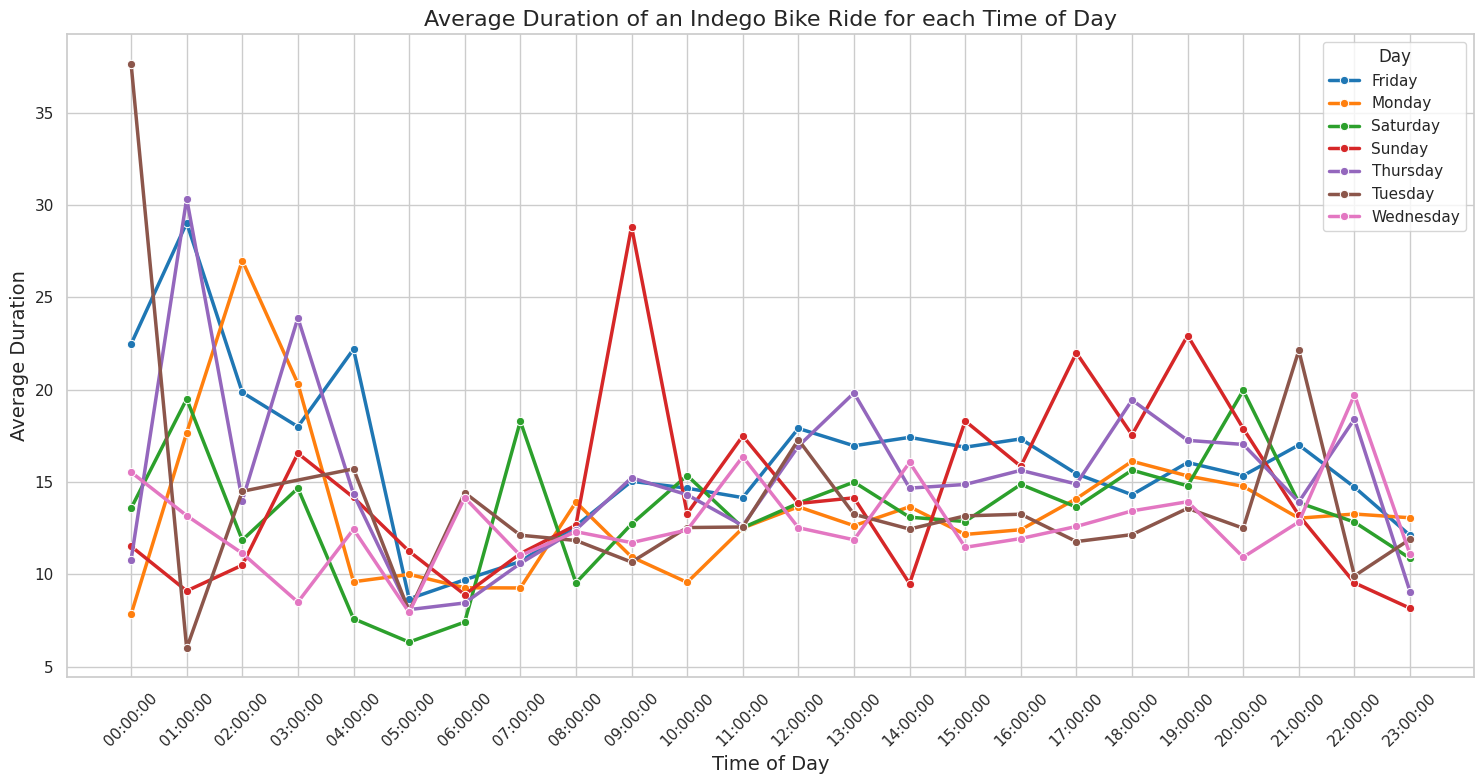

In [ ]:
# Second Plot:

plot2_df = selected_columns_df.drop(columns=['trip_id'])

avg_duration_df = plot2_df.groupby(['Day', 'Rounded_Time'])['duration'].mean().reset_index(name='Average Duration')

avg_duration_df.rename({'Rounded_Time': 'Time of Day'}, axis = 1, inplace=True)

avg_duration_df = avg_duration_df[['Day', 'Time of Day', 'Average Duration']]

avg_duration_df['Time of Day'] = avg_duration_df['Time of Day'].astype(str)

sns.set(style="whitegrid")

plt.figure(figsize=(15, 8))
line_plot = sns.lineplot(data=avg_duration_df, x='Time of Day', y='Average Duration', hue='Day', marker='o', palette='tab10', linewidth=2.5)

plt.title('Average Duration of an Indego Bike Ride for each Time of Day', fontsize=16)
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Average Duration', fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Part 4: Working with Text Data

###4.1 Tokenizing the text

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def tokenized_content(content):
    tokens = nltk.word_tokenize(content)

    cleaned_tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stopwords]

    return cleaned_tokens


In [ ]:
from collections import Counter

restaurant_counts = Counter(reviews_df['restaurant'])

most_reviewed_restaurant = restaurant_counts.most_common(1)[0][0]

restaurant_reviews_df = reviews_df[reviews_df['restaurant'] == most_reviewed_restaurant]

reviews = restaurant_reviews_df['review'].tolist()

top_tokens_list = [tokenized_content(review) for review in reviews]

top_tokens = [token for sublist in top_tokens_list for token in sublist]



### 4.2 Most Frequent Words

In [ ]:
tokens_counter = Counter(top_tokens)

top_ten_words = tokens_counter.most_common(10)

### 4.3 Word Clouds

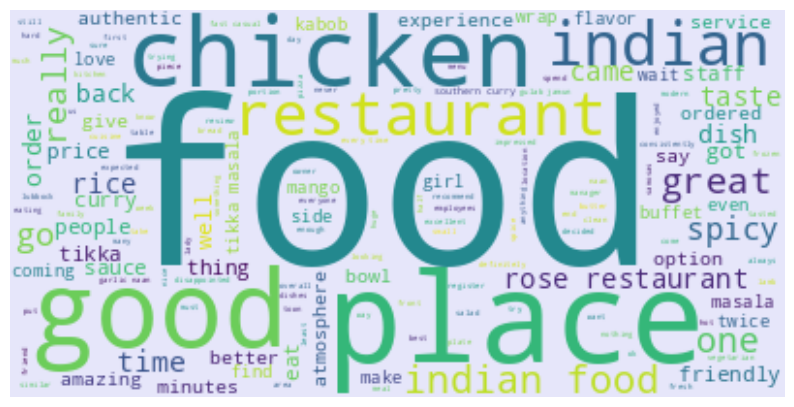

In [ ]:
text = ' '.join(top_tokens)

wordcloud = WordCloud(background_color='lavender').generate(text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()